# Second Submission: Corrected Feature Engineering

Implementation of unbiased feature engineering without temporal leakage for improved model generalization.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
train = pd.read_parquet('train.parquet', engine="fastparquet")
test = pd.read_parquet('test.parquet', engine="fastparquet")


print(f"\n Train shape: {train.shape}")
print(f" Test shape: {test.shape}")



 Train shape: (17499636, 19)
 Test shape: (4393179, 19)


In [3]:
user_churn = train.groupby('userId')['page'].apply(
    lambda x: 1 if 'Cancellation Confirmation' in x.values else 0
).reset_index()
user_churn.columns = ['userId', 'is_churner']

print(user_churn['is_churner'].value_counts())
print(f"Taux de churn: {user_churn['is_churner'].mean():.2%}")

is_churner
0    14869
1     4271
Name: count, dtype: int64
Taux de churn: 22.31%


In [4]:

print(train.columns.tolist())

print(train.head(3))

potential_label_cols = [col for col in train.columns if 'churn' in col.lower() or 'label' in col.lower() or 'target' in col.lower()]
print(f"\n Colonnes potentielles de label : {potential_label_cols}")

print(f"   Nombre de lignes (événements) : {len(train):,}")
print(f"   Nombre d'utilisateurs uniques : {train['userId'].nunique():,}")


['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts', 'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent', 'method', 'length', 'song', 'artist', 'time', 'registration']
      status gender firstName level lastName   userId             ts  \
0        200      M     Shlok  paid  Johnson  1749042  1538352001000   
992      200      M     Shlok  paid  Johnson  1749042  1538352525000   
1360     200      M     Shlok  paid  Johnson  1749042  1538352703000   

           auth      page  sessionId                         location  \
0     Logged In  NextSong      22683  Dallas-Fort Worth-Arlington, TX   
992   Logged In  NextSong      22683  Dallas-Fort Worth-Arlington, TX   
1360  Logged In  NextSong      22683  Dallas-Fort Worth-Arlington, TX   

      itemInSession                                          userAgent method  \
0               278  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...    PUT   
992             279  "Mozilla/5.0 (Windows NT 6.1; W

In [5]:
if 'is_churner' in train.columns:
    kaggle_churners = train.groupby('userId')['is_churner'].max()
else:
    kaggle_churners = user_churn.set_index('userId')['is_churner']

print(f"   Churners : {kaggle_churners.sum():,}")
print(f"   Non-churners : {(kaggle_churners == 0).sum():,}")
print(f"   Taux de churn : {kaggle_churners.mean() * 100:.2f}%")

your_churners = train.groupby('userId').apply(lambda x: (x['page'] == 'Cancellation Confirmation').any()).astype(int)
print(f"   Churners : {your_churners.sum():,}")
print(f"   Non-churners : {(your_churners == 0).sum():,}")
print(f"   Taux de churn : {your_churners.mean() * 100:.2f}%")

comparison_df = pd.DataFrame({
    'kaggle_is_churner': kaggle_churners,
    'your_churn': your_churners
})

print(pd.crosstab(comparison_df['kaggle_is_churner'], comparison_df['your_churn'],
                   rownames=['Kaggle is_churner'], colnames=['Ton churn']))

agreement = (comparison_df['kaggle_is_churner'] == comparison_df['your_churn']).mean()
print(f"\n Accord entre les deux labels : {agreement * 100:.2f}%")


   Churners : 4,271
   Non-churners : 14,869
   Taux de churn : 22.31%
   Churners : 4,271
   Non-churners : 14,869
   Taux de churn : 22.31%
Ton churn              0     1
Kaggle is_churner             
0                  14869     0
1                      0  4271

 Accord entre les deux labels : 100.00%
   Churners : 4,271
   Non-churners : 14,869
   Taux de churn : 22.31%
Ton churn              0     1
Kaggle is_churner             
0                  14869     0
1                      0  4271

 Accord entre les deux labels : 100.00%


/var/folders/rq/gbrjppds5pzc_g5hjfc4wvfc0000gn/T/ipykernel_868/2485757876.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  your_churners = train.groupby('userId').apply(lambda x: (x['page'] == 'Cancellation Confirmation').any()).astype(int)


In [6]:
columns_to_drop = [
    'firstName', 'lastName', 'status',
    'ts', 
    'auth',
    'method',
    'song',
    'location',
    'userAgent' 
]

train_clean = train.drop(columns=columns_to_drop)
test_clean = test.drop(columns=columns_to_drop)

print(f"Train shape après nettoyage: {train_clean.shape}")
print(f"Test shape après nettoyage: {test_clean.shape}")

Train shape après nettoyage: (17499636, 10)
Test shape après nettoyage: (4393179, 10)


In [7]:
def create_unbiased_features(df, user_churn_df=None, is_train=True):

    features = []

    for user_id, user_df in df.groupby('userId'):
        user_features = {'userId': user_id}

        user_features['gender'] = user_df['gender'].iloc[0]
        total_events = len(user_df)
        user_features['total_events'] = total_events
        user_features['num_sessions'] = user_df['sessionId'].nunique()

        time_min = user_df['time'].min()
        registration_time = user_df['registration'].iloc[0]
        user_features['days_since_registration'] = (time_min - registration_time).days

        active_days = user_df['time'].dt.date.nunique()
        user_features['active_days'] = active_days

        user_features['paid_ratio'] = (user_df['level'] == 'paid').mean()

        page_counts = user_df['page'].value_counts()

        thumbs_up = page_counts.get('Thumbs Up', 0)
        thumbs_down = page_counts.get('Thumbs Down', 0)
        user_features['thumbs_up_ratio'] = thumbs_up / total_events
        user_features['thumbs_down_ratio'] = thumbs_down / total_events
        user_features['add_playlist_ratio'] = page_counts.get('Add to Playlist', 0) / total_events
        user_features['add_friend_ratio'] = page_counts.get('Add Friend', 0) / total_events

        user_features['engagement_score'] = (thumbs_up - thumbs_down) / (thumbs_up + thumbs_down + 1)

        user_features['help_ratio'] = page_counts.get('Help', 0) / total_events
        user_features['error_ratio'] = page_counts.get('Error', 0) / total_events
        user_features['about_ratio'] = page_counts.get('About', 0) / total_events
        user_features['settings_ratio'] = page_counts.get('Settings', 0) / total_events

        session_lengths = user_df.groupby('sessionId').size()
        user_features['avg_session_length'] = session_lengths.mean()
        user_features['max_session_length'] = session_lengths.max()
        user_features['std_session_length'] = session_lengths.std() if len(session_lengths) > 1 else 0

        if 'artist' in user_df.columns:
            user_features['unique_artists'] = user_df[user_df['artist'].notna()]['artist'].nunique()
        else:
            user_features['unique_artists'] = 0

        nextsong_count = page_counts.get('NextSong', 0)
        user_features['nextsong_ratio'] = nextsong_count / total_events

        if 'length' in user_df.columns:
            avg_length = user_df[user_df['length'].notna()]['length'].mean()
            user_features['avg_song_length'] = avg_length if not pd.isna(avg_length) else 0
        else:
            user_features['avg_song_length'] = 0

        daily_events = user_df.groupby(user_df['time'].dt.date).size()
        user_features['events_per_active_day'] = total_events / active_days if active_days > 0 else 0
        user_features['activity_variance'] = daily_events.var() if len(daily_events) > 1 else 0

        user_features['events_per_session'] = total_events / user_features['num_sessions']
        user_features['sessions_per_active_day'] = user_features['num_sessions'] / active_days if active_days > 0 else 0

        if is_train and user_churn_df is not None:
            churn_value = user_churn_df[user_churn_df['userId'] == user_id]['is_churner'].values
            user_features['churn'] = churn_value[0] if len(churn_value) > 0 else 0

        features.append(user_features)

    return pd.DataFrame(features)


In [8]:

train_features_v2 = create_unbiased_features(train_clean, user_churn_df=user_churn, is_train=True)
test_features_v2 = create_unbiased_features(test_clean, user_churn_df=None, is_train=False)

print(f"\n Train features shape: {train_features_v2.shape}")
print(f" Test features shape: {test_features_v2.shape}")

print(f"\n Liste des features créées ({train_features_v2.shape[1] - 2} features):")
feature_cols = [col for col in train_features_v2.columns if col not in ['userId', 'churn']]
for i, feat in enumerate(feature_cols, 1):
    print(f"   {i:2d}. {feat}")

print(train_features_v2['churn'].value_counts())
print(f"   Taux de churn : {train_features_v2['churn'].mean() * 100:.2f}%")



 Train features shape: (19140, 27)
 Test features shape: (2904, 26)

 Liste des features créées (25 features):
    1. gender
    2. total_events
    3. num_sessions
    4. days_since_registration
    5. active_days
    6. paid_ratio
    7. thumbs_up_ratio
    8. thumbs_down_ratio
    9. add_playlist_ratio
   10. add_friend_ratio
   11. engagement_score
   12. help_ratio
   13. error_ratio
   14. about_ratio
   15. settings_ratio
   16. avg_session_length
   17. max_session_length
   18. std_session_length
   19. unique_artists
   20. nextsong_ratio
   21. avg_song_length
   22. events_per_active_day
   23. activity_variance
   24. events_per_session
   25. sessions_per_active_day
churn
0    14869
1     4271
Name: count, dtype: int64
   Taux de churn : 22.31%


In [9]:
from sklearn.preprocessing import LabelEncoder


train_features_v2_encoded = train_features_v2.copy()
test_features_v2_encoded = test_features_v2.copy()

train_features_v2_encoded['gender'] = train_features_v2_encoded['gender'].fillna('Unknown')
test_features_v2_encoded['gender'] = test_features_v2_encoded['gender'].fillna('Unknown')

all_genders = pd.concat([train_features_v2_encoded['gender'], test_features_v2_encoded['gender']]).unique()
le_v2 = LabelEncoder()
le_v2.fit(all_genders)

train_features_v2_encoded['gender'] = le_v2.transform(train_features_v2_encoded['gender'])
test_features_v2_encoded['gender'] = le_v2.transform(test_features_v2_encoded['gender'])

print(f" Genre encodé: {dict(zip(le_v2.classes_, le_v2.transform(le_v2.classes_)))}")

X_full_v2 = train_features_v2_encoded.drop(columns=['userId', 'churn'])
y_full_v2 = train_features_v2_encoded['churn']
X_test_v2 = test_features_v2_encoded.drop(columns=['userId'])

print(f"   X_full_v2: {X_full_v2.shape}")
print(f"   y_full_v2: {y_full_v2.shape}")
print(f"   X_test_v2: {X_test_v2.shape}")

from sklearn.model_selection import train_test_split
X_train_v2, X_val_v2, y_train_v2, y_val_v2 = train_test_split(
    X_full_v2, y_full_v2,
    test_size=0.2,
    random_state=42,
    stratify=y_full_v2
)

print(f"   Train: {len(X_train_v2)} ({y_train_v2.mean()*100:.2f}% churn)")
print(f"   Val:   {len(X_val_v2)} ({y_val_v2.mean()*100:.2f}% churn)")


 Genre encodé: {'F': np.int64(0), 'M': np.int64(1), 'Unknown': np.int64(2)}
   X_full_v2: (19140, 25)
   y_full_v2: (19140,)
   X_test_v2: (2904, 25)
   Train: 15312 (22.32% churn)
   Val:   3828 (22.31% churn)


In [10]:
from xgboost import XGBClassifier

scale_pos_weight = (y_train_v2 == 0).sum() / (y_train_v2 == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

model_v2 = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc'
)


model_v2.fit(
    X_train_v2, y_train_v2,
    eval_set=[(X_val_v2, y_val_v2)],
    verbose=False
)

y_pred_v2 = model_v2.predict(X_val_v2)
y_pred_proba_v2 = model_v2.predict_proba(X_val_v2)[:, 1]

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

auc_v2 = roc_auc_score(y_val_v2, y_pred_proba_v2)
print(f"\n ROC-AUC Score sur validation: {auc_v2:.4f}")

print(classification_report(y_val_v2, y_pred_v2, target_names=['Non-Churn', 'Churn']))

cm = confusion_matrix(y_val_v2, y_pred_v2)
print(cm)


scale_pos_weight: 3.48

 ROC-AUC Score sur validation: 0.7747
              precision    recall  f1-score   support

   Non-Churn       0.87      0.79      0.83      2974
       Churn       0.45      0.60      0.51       854

    accuracy                           0.75      3828
   macro avg       0.66      0.69      0.67      3828
weighted avg       0.78      0.75      0.76      3828

[[2343  631]
 [ 345  509]]


                feature  importance
sessions_per_active_day    0.118766
             paid_ratio    0.069957
        thumbs_up_ratio    0.060509
       engagement_score    0.058932
         nextsong_ratio    0.057832
  events_per_active_day    0.057595
            active_days    0.054748
     events_per_session    0.050130
     avg_session_length    0.041229
           num_sessions    0.039493
      thumbs_down_ratio    0.032314
     std_session_length    0.031703
       add_friend_ratio    0.031084
     max_session_length    0.029430
days_since_registration    0.028898


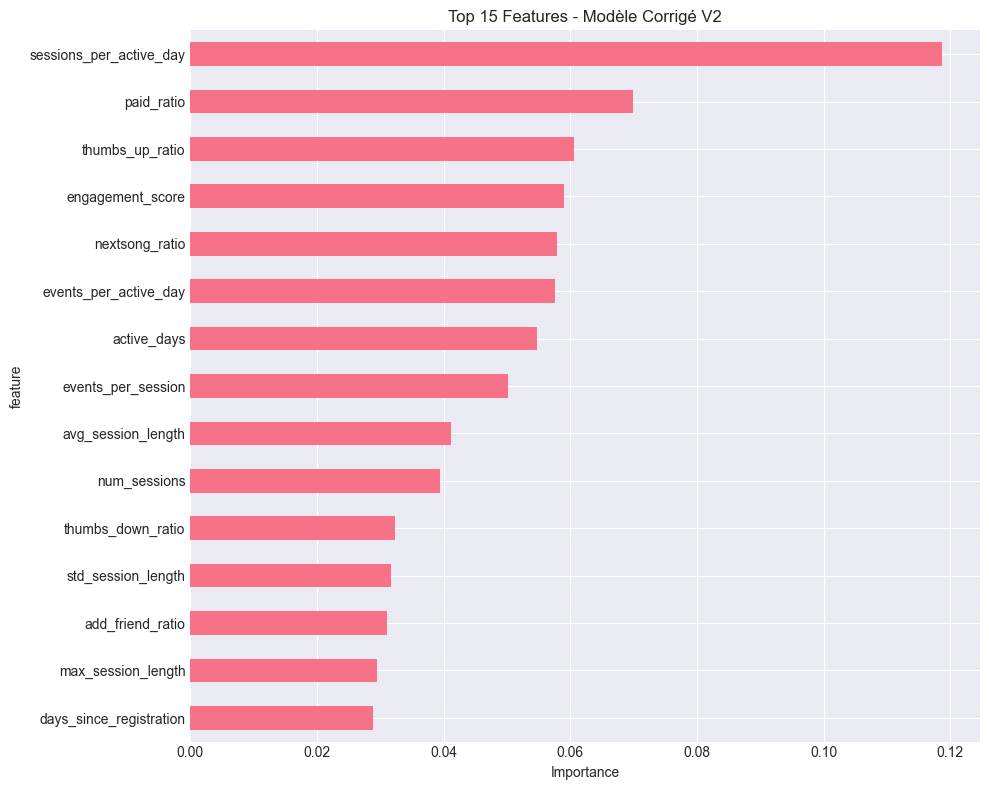

In [11]:
# Analyse des features importantes
import matplotlib.pyplot as plt

feature_importance_v2 = pd.DataFrame({
    'feature': X_full_v2.columns,
    'importance': model_v2.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_v2.head(15).to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 8))
feature_importance_v2.head(15).plot(kind='barh', x='feature', y='importance', ax=ax, legend=False)
ax.set_xlabel('Importance')
ax.set_title('Top 15 Features - Modèle Corrigé V2')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:

final_model_v2 = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc'
)

final_model_v2.fit(X_full_v2, y_full_v2, verbose=False)

test_predictions_v2 = final_model_v2.predict_proba(X_test_v2)[:, 1]

print(f"   Min: {test_predictions_v2.min():.4f}")
print(f"   Max: {test_predictions_v2.max():.4f}")
print(f"   Mean: {test_predictions_v2.mean():.4f}")
print(f"   Median: {np.median(test_predictions_v2):.4f}")

test_pred_binary = (test_predictions_v2 > 0.5).astype(int)
print(f"\n Taux de churn prédit sur test (seuil 0.5): {test_pred_binary.mean() * 100:.2f}%")
print(f"   (Pour comparaison, taux de churn train: {y_full_v2.mean() * 100:.2f}%)")


   Min: 0.0124
   Max: 0.9496
   Mean: 0.3660
   Median: 0.3588

 Taux de churn prédit sur test (seuil 0.5): 24.21%
   (Pour comparaison, taux de churn train: 22.31%)


In [13]:

test_predictions_binary = (test_predictions_v2 > 0.5).astype(int)

submission_v2 = pd.DataFrame({
    'id': test_features_v2_encoded['userId'],
    'prediction': test_predictions_binary
})

submission_filename = 'submission_2.csv'
submission_v2.to_csv(submission_filename, index=False)

print(f"\n Fichier de soumission créé: {submission_filename}")
print(f"   Nombre de prédictions: {len(submission_v2):,}")

print(submission_v2.head(10))

print(submission_v2['prediction'].value_counts())
print(f"\n   Taux de churn prédit: {submission_v2['prediction'].mean() * 100:.2f}%")
print(f"   (Pour comparaison, taux de churn train: {y_full_v2.mean() * 100:.2f}%)")



 Fichier de soumission créé: submission_2.csv
   Nombre de prédictions: 2,904
        id  prediction
0  1000655           0
1  1000963           0
2  1001129           1
3  1001963           0
4  1002283           1
5  1002397           0
6  1002533           0
7  1002712           0
8  1002879           0
9  1003703           0
prediction
0    2201
1     703
Name: count, dtype: int64

   Taux de churn prédit: 24.21%
   (Pour comparaison, taux de churn train: 22.31%)
